In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Network

In [7]:
"IMPORT"

G = nx.read_edgelist("G_top_proj_LCC.edgelist") # Link weights imported as well
# G = nx.read_weighted_edgelist("G_top_proj_LCC.edgelist")

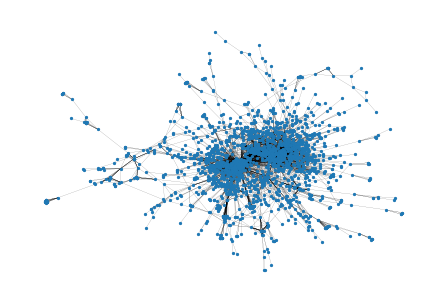

In [8]:
"DRAW"

pos = nx.spring_layout(G, scale=2)
# pos = nx.kamada_kawai_layout(G)

nx.draw(G, width=0.1, node_size=5, pos=pos)

In [9]:
"RE-LABLE NODES FOR EASE (0 to N-1)"

G = nx.convert_node_labels_to_integers(G,first_label=0, ordering='default', label_attribute="Id")
G.nodes.data()[0]

{'Id': '1035970130591842304'}

# Defining custom functions

In [10]:
"INFO - Network Statistics"

def info(G, return_values=False):
    # f = nx.degree_histogram(G)
    # plt.hist(f, bins=50)
    
    N = G.number_of_nodes()
    L = G.number_of_edges()
    p = nx.density(G)
    status = nx.is_directed(G)

    # Average degree
    total_k = sum(dict(G.degree).values())
    N = int(G.number_of_nodes())
    avg_k = total_k/N
    # p = avg_k / (N-1) #p and density are same
    # print("Link Probability =",p)
    
    # Shortest Path
    s_path = nx.average_shortest_path_length(G)
    
    print("Directed =",status)
    print("Density =",p)
    print("Average degree =",avg_k)
    print("Average Shortest Path =",s_path)
    print(nx.info(G))
    
    nodes = list(G.nodes())
    edges = list(G.edges())
    
    # Plotting degree Distribution
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    plt.figure(figsize=(6, 4)) 
    plt.loglog(degrees, degree_freq,'o') 
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title("Degree Distribution (log-log)")
    plt.show()
    
    # Clustering
    C = nx.clustering(G)
    c = list(C.values())
    plt.hist(c, bins=10, range=[0, 1])
    plt.title("Clustering")
    plt.show()
    
    
    if return_values == True:
        return avg_k, p, N, L, nodes, edges
    else:
        return

"(RE)SET Attributes"

def reset(G):
    # Boolean attribute for infected = 1 or not infected = 0
    nx.set_node_attributes(G,0,"infected")
    nx.set_node_attributes(G,0,"time")

"Initial Infection"
    
def infect_node(G, n=1):

    # Randomly selecting nodes
    infected_node_list = np.random.randint(0,G.number_of_nodes()-1, size = n)
    
    # Infecting them
    for i in infected_node_list:
        G.nodes[i]['infected'] = 1

"Plot the network, red for infected, grey for recovered"

def plot(G, title=None):
    
    color_map = nx.get_node_attributes(G, 'infected')
    
    pos = nx.spring_layout(G, scale=2)
    
    for key in color_map:
        if color_map[key] == 1:
            color_map[key] = "red"
        elif color_map[key] == 2:
            color_map[key] = "grey"
        else:
            color_map[key] = "green"
            
    node_colors = [color_map.get(node) for node in G.nodes()]
    
    nx.draw(G, pos=pos, node_color = node_colors, node_size=5, width=0.1)
    plt.title(title)
    plt.show()    

"CUSTOM FUNCTION"
def find_specific_attribute_node(G, attr, value):

    result = []

    d = nx.get_node_attributes(G, attr)

    for key, v in d.items():
        if(v == value):
            result.append(key)

    return result

# SIR Function

In [29]:
def spread_SIR(G,p,r,iterations,weighted=False):
    """
    p = infection rate
    r = recovery time
    iterations = number of time frames to simulate
    weighted = to consider link weights
    """
    counter = 0
#     infected = [0]
    I = []
    t = []
    R = []
    S = []
    
    while True:
#         print(counter)
        # loop thorugh each node
        for node in range(G.number_of_nodes()):
            # inspect each node if its infected
            if G.nodes[node]['infected'] == 1:
                # get neighbours of an infected node
                neighbor_list = G.neighbors(node)
                # loop through each neighbour
                for neighbor in neighbor_list:
                    # prob = np.random.uniform(0,1)
                    # Multiply link weight with infection rate
                    if weighted == True:
                        prob_weight = p * G[node][neighbor]['weight']
                        prob = np.random.binomial(1,prob_weight,1)
                    else:
                        prob = np.random.binomial(1,p,1)
                    # infect if it is not infected already
                    if G.nodes[neighbor]['infected'] == 0:
                        # infect neighbour if binomial decision is 1
                        if prob==1:
                            G.nodes[neighbor]['infected'] = 1
                            G.nodes[neighbor]['time'] = counter
                            
   
        counter += 1
        
        # Removal/Recovery of nodes at r time after infection
        infected_nodes = find_specific_attribute_node(G,'infected', 1)
        for i in infected_nodes:
            # Probability based
            prob = np.random.binomial(1,r,1)
            if prob == 1:
                G.nodes[i]['infected'] = 2
            # Time limit based
#             if counter - G.nodes[i]['time'] >= r:
#                 G.nodes[i]['infected'] = 2
        
        I.append(len(infected_nodes))
        
        susceptible_nodes = find_specific_attribute_node(G,'infected',0)
        S.append(len(susceptible_nodes))
        
        
        recovered_nodes = find_specific_attribute_node(G,'infected', 2)
        R.append(len(recovered_nodes))
#         R.append(len(recovered_nodes))
        t.append(counter)
        
        if counter>iterations:
            break
            
    return I, t, R, S # returning list of infection numbers and time steps
    

def SIR(G,p,r, iterations, weighted=False):
    """
    p = infection rate
    r = recovery time
    iterations = number of time frames to simulate
    weighted = to consider link weights
    """
    reset(G)
    infect_node(G)
    plot(G, "First Infection")

    I, t, R, S = spread_SIR(G,p,r,iterations)
    
    plot(G, title=f"time = {t[-1]}")    
    
    N = G.number_of_nodes()
    plt.plot(t,I, "r", label="Infection")
    plt.plot(t,R, "g", label="Recovered")
    plt.plot(t,S, "b", label="Susceptible")

    # plt.axhline(N, ls=':', lw=1)
    plt.xlabel(r'$t$', fontsize=16)
    plt.ylabel(r'$I(t)$', fontsize=16)
    plt.legend()
    plt.show()

# Spreading Phenomina on Real Network

Directed = False
Density = 0.03300248859346277
Average degree = 96.82930153321976
Average Shortest Path = 4.144452921687692
Graph with 2935 nodes and 142097 edges


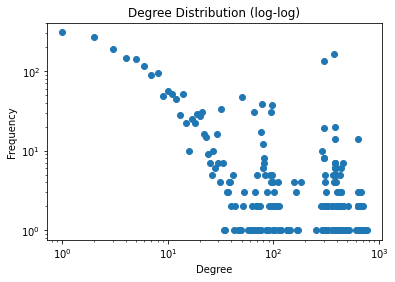

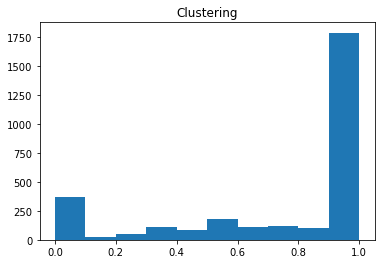

In [12]:
avg_k, p, N, L, nodes, edges = info(G, return_values=True)

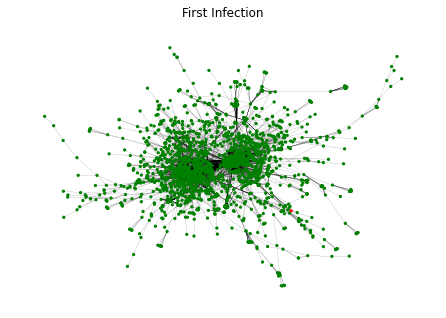

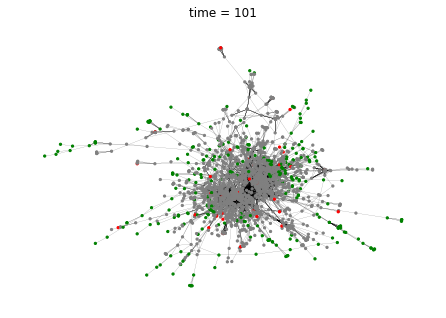

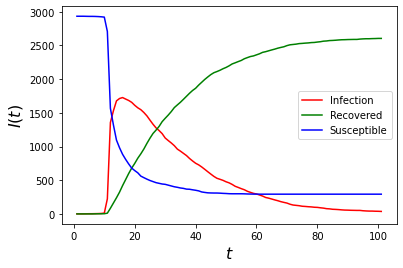

In [33]:
SIR(G,p=0.1,r=0.05,iterations=100,weighted=True)

# Comparison Networks

In [14]:
# ER and BA models
n = G.number_of_nodes()
p = nx.density(G) # from info of G


G_ER = nx.erdos_renyi_graph(n, p, seed=None, directed=False)
G_BA = nx.barabasi_albert_graph(n, m=50)

Directed = False
Density = 0.0331385889918932
Average degree = 97.22862010221465
Average Shortest Path = 2.0053736432056057
Graph with 2935 nodes and 142683 edges


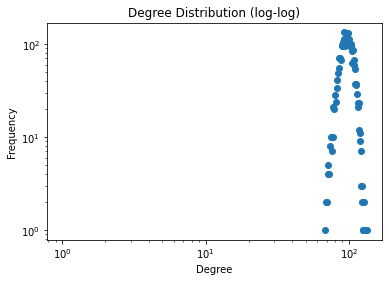

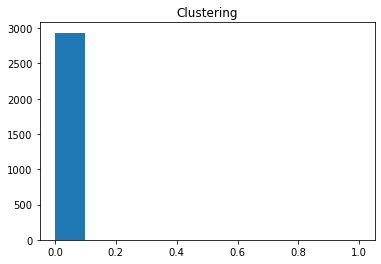

ER None

Directed = False
Density = 0.033502529818412806
Average degree = 98.29642248722317
Average Shortest Path = 2.025112149283092
Graph with 2935 nodes and 144250 edges


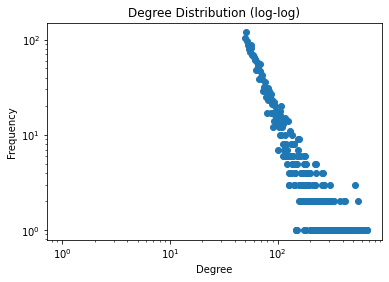

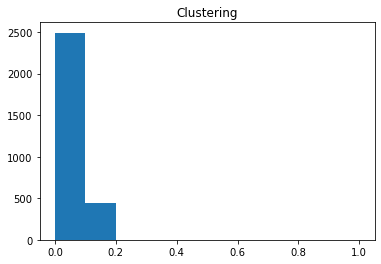

BA None


In [15]:
print("ER",info(G_ER))
print()
print("BA",info(G_BA))

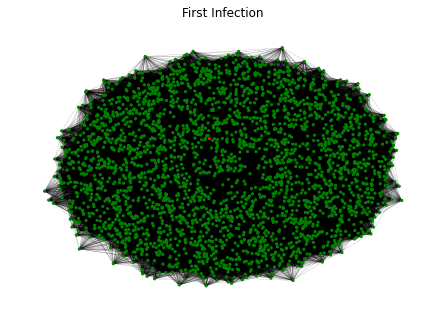

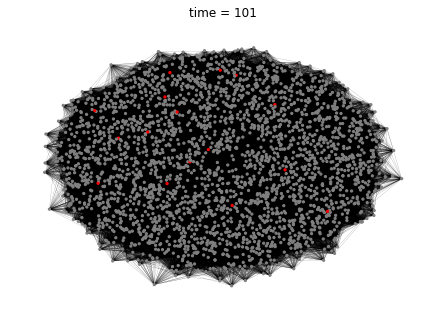

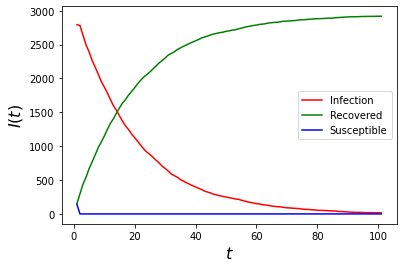

In [35]:
SIR(G_ER,p=0.1,r=0.05, iterations=100)

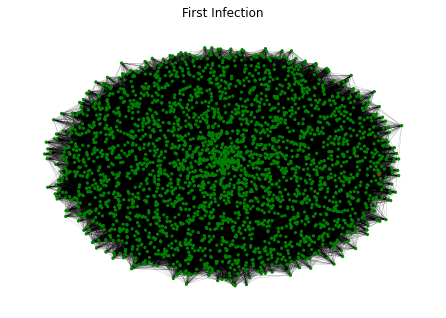

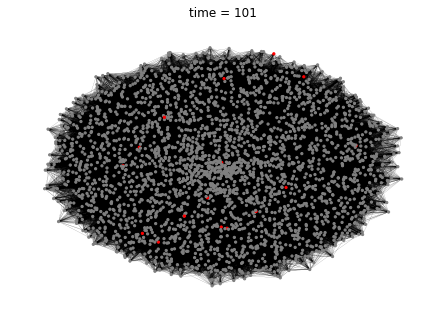

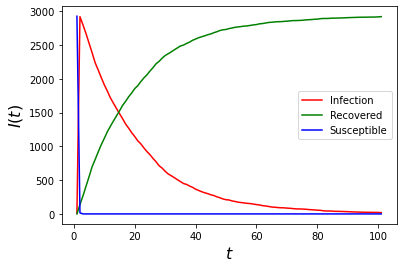

In [36]:
SIR(G_BA,p=0.1,r=0.05, iterations=100)

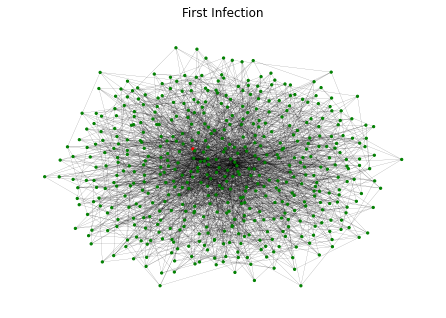

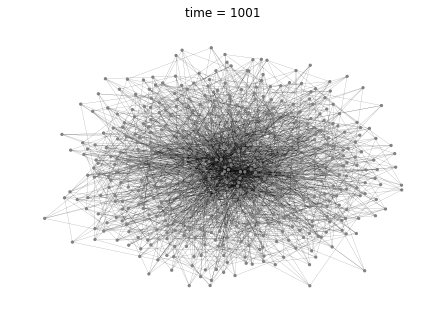

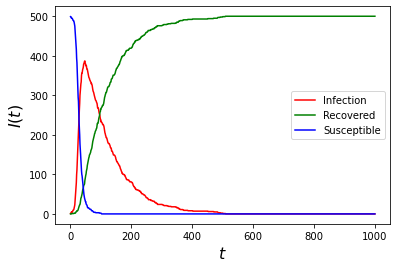

In [31]:
# Testing
g = nx.barabasi_albert_graph(500, m=5)
SIR(g, p=0.02, r=0.01,iterations=1000)